#  Использование одномерных сверток в PyTorch

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html#torch.nn.MaxPool1d
* https://wandb.ai/wandb_fc/wb-tutorials/reports/Tutorial-Text-Classification-Using-CNNs--Vmlldzo0NTIxNDI5
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

## Задачи для совместного разбора

1\. Изучите принцип работы одномерных сверточных слоев в `torch`

![1d conv](https://raw.githubusercontent.com/krzjoa/krzjoa.github.io/master/assets/img/2020-10-03-ts-and-torch-1/conv1d.gif)

![conv1d](https://api.wandb.ai/files/wandb_fc/images/projects/37754834/1f7be456.gif)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
X = th.randint(0, 10, size=(10, 1, 6)).float()
X.shape

torch.Size([10, 1, 6])

In [ ]:
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, bias=False)

In [ ]:
out = conv(X)
out.shape

torch.Size([10, 1, 4])

In [ ]:
conv.weight

Parameter containing:
tensor([[[ 0.2992,  0.2599, -0.3190]]], requires_grad=True)

In [ ]:
conv = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=2)

In [ ]:
conv.weight.shape

torch.Size([1, 4, 2])

In [ ]:
batch_size = 16
emb_dim = 4
seq_len = 6
X = th.rand(batch_size, emb_dim, seq_len)
out = conv(X)
out.shape

torch.Size([16, 1, 5])

## Задачи для самостоятельного решения

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torchmetrics as M
import matplotlib.pyplot as plt

<p class="task" id="1"></p>

1\. Загрузите данные из файла `ts.csv`. Используя модель, состоящую из одного одномерного сверточного слоя, решите задачу предсказания $y_t$ по `k` предыдущим точкам временного ряда $x_{t-k}...x_{t-1}$. Исследуйте значения $k\in[1, 7]$. Для каждого $k$ выведите на экран итоговое значение функции потерь и веса ядра свертки. Визуализируйте исходный временной ряд и полученные прогнозы.

- [ ] Проверено на семинаре

In [ ]:
ts = pd.read_csv('ts.csv')
ts.head()

,x,y
0,-2.103694,-1.156378
1,-1.081334,0.008044
2,17.530135,-4.130848
3,16.535054,-3.007267
4,20.868080,2.944139


In [ ]:
X = th.tensor(ts['x']).view(1, 1, 1005).float()
y = th.tensor(ts['y']).float()

In [ ]:
convs = [
    nn.Conv1d(in_channels=1, out_channels=1, kernel_size=k)
    for k in range(1, 8)
]

In [ ]:
n_epoch = 100
lr = 0.1
crit = nn.MSELoss()
loss_curve = []

for k, conv in enumerate(convs):
  optimizer = optim.Adam(conv.parameters(), lr=lr)
  curve = []
  for epoch in range(1, n_epoch + 1):
    out = conv(X)
    loss = crit(out[0, 0], y[k:])
    curve.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 25 == 0:
      print(f'{epoch=} {loss.item()=}')
  print(f'{(k+1)=} {loss.item()=}')
  print(f'weight = {conv.weight}')
  loss_curve.append(curve)

epoch=25 loss.item()=36.10427474975586
epoch=50 loss.item()=18.28447914123535
epoch=75 loss.item()=15.88959789276123
epoch=100 loss.item()=15.8576078414917
(k+1)=1 loss.item()=15.8576078414917
weight = Parameter containing:
tensor([[[0.3681]]], requires_grad=True)
epoch=25 loss.item()=3.537858009338379
epoch=50 loss.item()=3.204529047012329
epoch=75 loss.item()=3.0910804271698
epoch=100 loss.item()=3.0880727767944336
(k+1)=2 loss.item()=3.0880727767944336
weight = Parameter containing:
tensor([[[0.3769, 0.0174]]], requires_grad=True)
epoch=25 loss.item()=5.822420120239258
epoch=50 loss.item()=2.226088523864746
epoch=75 loss.item()=1.9226913452148438
epoch=100 loss.item()=1.90839421749115
(k+1)=3 loss.item()=1.90839421749115
weight = Parameter containing:
tensor([[[0.1140, 0.2809, 0.0073]]], requires_grad=True)
epoch=25 loss.item()=5.423701286315918
epoch=50 loss.item()=4.867856979370117
epoch=75 loss.item()=1.8740578889846802
epoch=100 loss.item()=1.4936531782150269
(k+1)=4 loss.item()

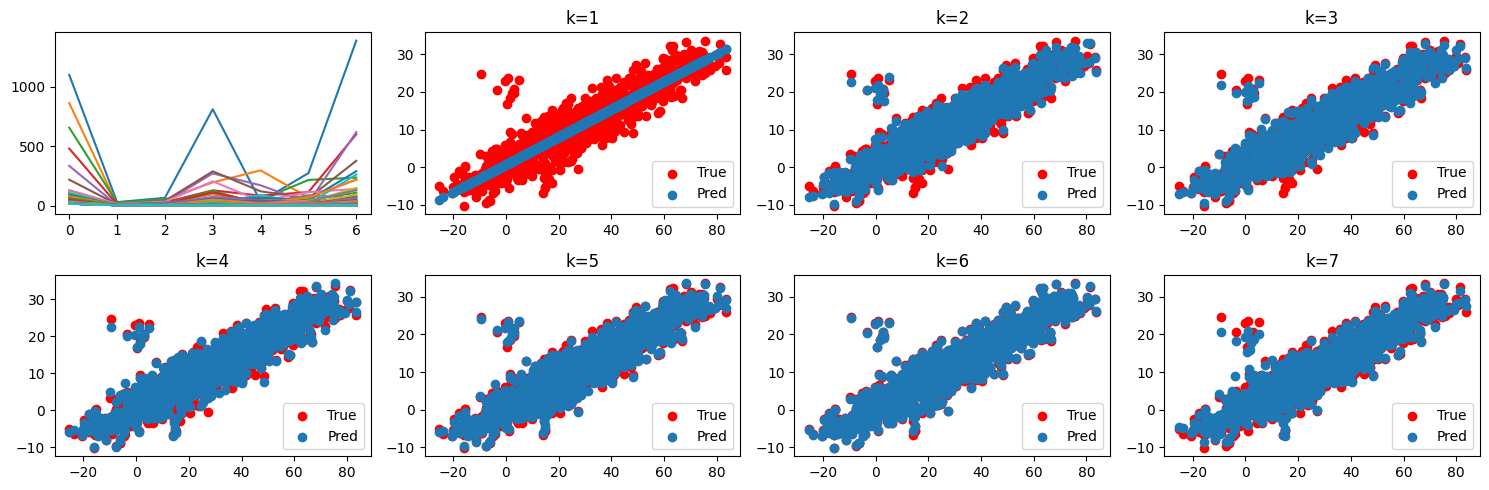

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(15, 5))

ax.ravel()[0].plot(loss_curve)
for idx, axis in enumerate(ax.ravel()):
  if idx >= 2:
    axis.scatter(X[0, 0][(idx-1):], y[(idx-1):], label='True', color='r')
    axis.scatter(X[0, 0][(idx-1):], convs[idx-1](X)[0, 0].detach().numpy(), label='Pred')
    axis.legend()
    axis.set_title(f'k={idx}')
  elif idx == 1:
    axis.scatter(X[0, 0], y, label='True', color='r')
    axis.scatter(X[0, 0], convs[idx-1](X)[0, 0].detach().numpy(), label='Pred')
    axis.legend()
    axis.set_title(f'k={idx}')
plt.tight_layout()

<p class="task" id="2"></p>

2\. Загрузите файл `PV_Elec_Gas2.csv`. Опишите класс `ElectricityDataset`, который разбивает данные на окна в соответствии со следующей схемой:

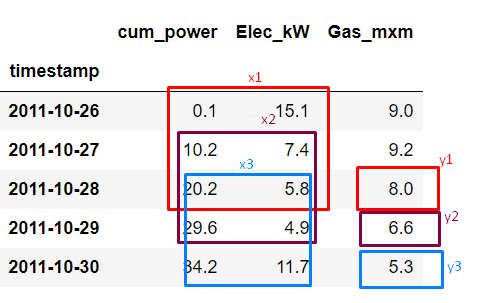

Разбейте набор данных на обучающую и тестовую выборку. Для теста оставьте данные за 2019 год.

- [ ] Проверено на семинаре

In [ ]:
df = pd.read_csv('PV_Elec_Gas2.csv')
df.head(2)

,Unnamed: 0,cum_power,Elec_kW,Gas_mxm
0,2011-10-26,0.1,15.1,9.0
1,2011-10-27,10.2,7.4,9.2


In [ ]:
class ElectricityDataset:
  def __init__(self, X, y, window=3):
    win_data = []
    for i in range(len(X) - window + 1):
      win_data.append(X[i:i+window])
    self.win_tensor = th.tensor(np.array(win_data))
    self.y = th.tensor(y[window - 1:])

  def __getitem__(self, idx):
    return self.win_tensor[idx], self.y[idx]

  def __len__(self):
    return len(self.win_tensor)

In [ ]:
df['Unnamed: 0'] = df['Unnamed: 0'].apply(lambda x: x[:4])

In [ ]:
train = df[df['Unnamed: 0'] != '2019']
test = df[df['Unnamed: 0'] == '2019']
train.shape, test.shape

((2624, 4), (324, 4))

In [ ]:
X_train, y_train = train[['cum_power', 'Elec_kW']].values, train['Gas_mxm'].values
X_test, y_test = test[['cum_power', 'Elec_kW']].values, test['Gas_mxm'].values
train_dataset = ElectricityDataset(X_train, y_train)
test_dataset = ElectricityDataset(X_test, y_test)

In [ ]:
train_dataset[:3]

(tensor([[[ 0.1000, 15.1000],
          [10.2000,  7.4000],
          [20.2000,  5.8000]],
 
         [[10.2000,  7.4000],
          [20.2000,  5.8000],
          [29.6000,  4.9000]],
 
         [[20.2000,  5.8000],
          [29.6000,  4.9000],
          [34.2000, 11.7000]]], dtype=torch.float64),
 tensor([8.0000, 6.6000, 5.3000], dtype=torch.float64))

<p class="task" id="3"></p>

3\. Решите задачу предсказания столбца `Gas_mxm` на основе столбцов `cum_power` и `Elec_kW` с использованием одномерных сверток. Для оптимизации используйте мини-пакетный градиентный спуск с использованием `DataLoader`. Обратите внимание, что при создании `DataLoader` вы не можете перемешивать данные.

Постройте график изменения значения функции потерь на обучающем и тестовом множестве в зависимости от номера эпохи. Визуализируйте на одном графике прогнозы модели и предсказываемый временной ряд.

- [ ] Проверено на семинаре

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

In [ ]:
n_epoch = 100
lr = 0.1
model = nn.Sequential(
    nn.Conv1d(in_channels=3, out_channels=16, kernel_size=2),
    nn.ReLU(),
    nn.Conv1d(in_channels=16, out_channels=1, kernel_size=1),
    nn.ReLU(),
    nn.Linear(in_features=1, out_features=1)
)
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.MSELoss()
loss_curve = []
preds_test = th.Tensor()
preds_train = th.Tensor()

for epoch in range(1, n_epoch + 1):
  for X_b, y_b in train_loader:
    out = model(X_b.float())
    loss = crit(out[:, 0, 0], y_b.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  loss_curve.append(loss.item())
  if epoch % 10 == 0:
    print(f'{epoch=} {loss.item()=}')

for X_b, y_b in train_loader:
  out = model(X_b.float())
  preds_train = th.cat([preds_train, out[:, 0, 0]])

for X_b, y_b in test_loader:
  out = model(X_b.float())
  preds_test = th.cat([preds_test, out[:, 0, 0]])

epoch=10 loss.item()=30.00718879699707
epoch=20 loss.item()=27.408994674682617
epoch=30 loss.item()=27.39527130126953
epoch=40 loss.item()=27.399377822875977
epoch=50 loss.item()=27.40196418762207
epoch=60 loss.item()=27.403705596923828
epoch=70 loss.item()=27.404916763305664
epoch=80 loss.item()=27.405790328979492
epoch=90 loss.item()=27.40644073486328
epoch=100 loss.item()=27.406940460205078


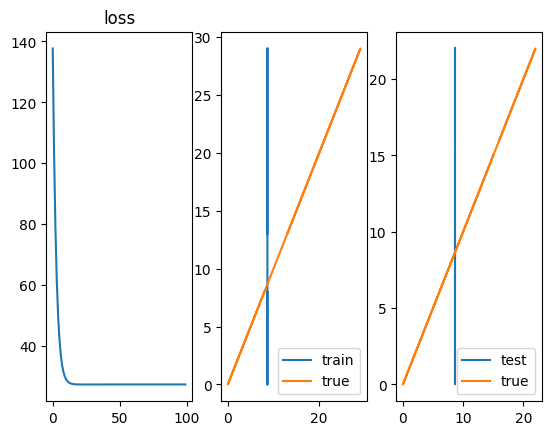

In [ ]:
fig, ax = plt.subplots(ncols=3)
ax[0].plot(loss_curve)
ax[0].set_title('loss')
ax[1].plot(preds_train.detach().numpy(), train_dataset[:][1], label='train')
ax[2].plot(preds_test.detach().numpy(), test_dataset[:][1], label='test')
ax[1].plot(train_dataset[:][1], train_dataset[:][1], label='true')
ax[2].plot(test_dataset[:][1], test_dataset[:][1], label='true')
ax[1].legend()
ax[2].legend();

**Тут если линии совпадут, значит модели хорошо предсказывают $y_t$**

<p class="task" id="4"></p>

4\. Считайте файлы `polarity/positive_reviews.csv` (положительные обзоры на фильмы) и `polarity/negative_reviews.csv` (отрицательные обозоры на фильмы) и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Vocab на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре.

Создайте класс `PolarityDataset` и реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов (слов) для текста и метки классов для этих текстов. Создайте два объекта класса `PolarityDataset` для обучающей и тестовой выборки. Выведите на экраны количество элементов и распределение данных по классам в каждом из них.

- [ ] Проверено на семинаре

In [3]:
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import re
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def processing(text):
  tokenizer = RegexpTokenizer(r'\w+')
  res = []
  text = re.sub(r'<.*?>', ' ', text)
  tokens = tokenizer.tokenize(re.sub(r'[^A-Za-z ]', ' ', text))
  for tok in tokens:
    if tok not in sw:
      res.append(tok.lower())
  return [res]

In [5]:
neg = pd.read_csv('negative_reviews.txt', sep='\t', header=None)
pos = pd.read_csv('positive_reviews.txt', sep='\t', header=None)
neg[1] = 0
pos[1] = 1
neg.head()

,0,1
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0


In [6]:
df = pd.concat([neg, pos])
df[0] = df[0].apply(processing)
df.shape

(10662, 2)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.2, random_state=42)

In [8]:
corpus = X_train.sum()
vocab = build_vocab_from_iterator(corpus, specials=['<PAD>', '<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [9]:
from torch.utils.data import Dataset

class PolarityDataset(Dataset):
  def __init__(self, X, y):
    super().__init__()
    self.X = X.sum()
    self.y = np.array(y)
    self.transforms = T.Sequential(
        T.ToTensor(0),
        T.PadTransform(max_length=50, pad_value=0)
    )

  def __getitem__(self, idx):
    if isinstance(idx, slice):
      res = []
      for text in self.X[idx]:
        res.append(vocab.lookup_indices(text))
      return self.transforms(res), th.tensor(list(self.y[idx]))
    else:
      return self.transforms(vocab.lookup_indices(self.X[idx])), th.tensor([self.y[idx]])

  def __len__(self):
    return len(self.X)

In [10]:
train_dataset = PolarityDataset(X_train, y_train)
test_dataset = PolarityDataset(X_test, y_test)

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=128
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128
)

In [12]:
print(f'train: count={len(train_dataset)}, positive={train_dataset[:][1].sum().item()}')
print(f'test: count={len(test_dataset)}, positive={test_dataset[:][1].sum().item()}')

train: count=8529, positive=4260
test: count=2133, positive=1071


<p class="task" id="5"></p>

5\. Решите задачу классификации текстов обзоров с использованием одномерных сверток. Для преобразования последовательности индексов в последовательность векторов используйте слой `nn.Embedding`. Обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`. Выведите на экран отчет по классификации для обучающей и тестовой выборки после завершения процесса обучения. Добейтесь accuracy на тестовой выборке не менее 70%.

- [ ] Проверено на семинаре

In [63]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=len(vocab), embedding_dim=200)
    self.conv1 = nn.Conv1d(in_channels=200, out_channels=32, kernel_size=5)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=1, kernel_size=3)
    self.fc1 = nn.Linear(in_features=44, out_features=32)
    self.fc2 = nn.Linear(in_features=32, out_features=16)
    self.fc3 = nn.Linear(in_features=16, out_features=2)
    self.relu = nn.ReLU()

  def forward(self, X):
    e = self.emb(X)
    out = self.conv1(e.view(-1, 200, 50))
    out = self.conv2(out)
    out = self.relu(out)
    out = self.fc1(out)
    out = nn.Dropout(p=0.1)(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)

    return out

In [64]:
n_epoch = 30
lr = 0.01
model = Model()
model.to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
loss_curve = []
acc_curve_train = []
acc_curve_test = []

for epoch in range(1, n_epoch + 1):
  acc = M.Accuracy(task='binary', num_classes=2)
  for X_b, y_b in train_loader:
    o = model(X_b.to(device='cuda').long())
    loss = crit(o[:, 0, :], th.flatten(y_b.to(device='cuda')))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc.update(th.argmax(o[:, 0, :].to(device='cpu'), dim=1), th.flatten(y_b))
  loss_curve.append(loss.item())
  acc_curve_train.append(acc.compute())

  acc = M.Accuracy(task='binary', num_classes=2)
  model.eval()
  for X_b, y_b in test_loader:
    o = model(X_b.to(device='cuda').long())
    acc.update(th.argmax(o[:, 0, :].to(device='cpu'), dim=1), th.flatten(y_b))
  model.train()
  acc_curve_test.append(acc.compute())
  if epoch % 10 == 0:
    print(f'{epoch=} {loss.item()=}')

epoch=10 loss.item()=8.491732614857028e-07
epoch=20 loss.item()=6.078156502553611e-07
epoch=30 loss.item()=4.758624072564999e-06


In [65]:
acc_curve_test[-1]

tensor(0.7014)

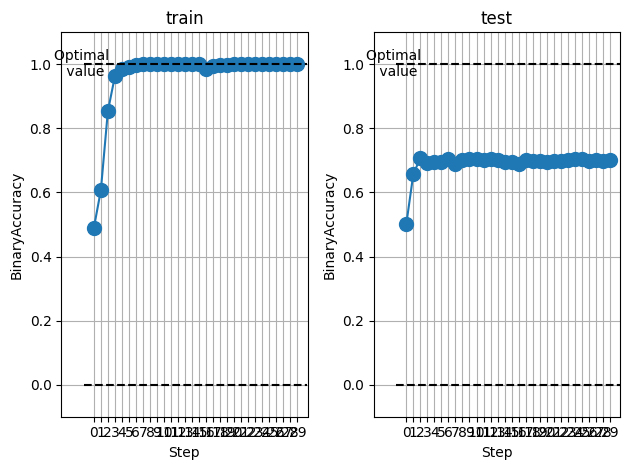

In [67]:
fig, ax = plt.subplots(ncols=2)
acc.plot(acc_curve_train, ax=ax[0])
ax[0].set_title('train')
acc.plot(acc_curve_test, ax=ax[1])
ax[1].set_title('test')
plt.tight_layout()

<p class="task" id="6"></p>

6\. Придумайте небольшой отзыв, прогоните его через модель и выведите метку предсказанного класса (позитивный или негативный). Сделайте это для явно позитивного и явно негативного отзыва.

- [ ] Проверено на семинаре

In [62]:
negative = "such a filthy disgusting and pathetic film never gonna watch this film"
text = vocab.lookup_indices(negative.split())
while len(text) < 50:
  text.append(0)
text = th.tensor(text).view(1, 50)
out = model(text.to(device='cuda'))
th.argmax(out[:, 0, :].to(device='cpu'), dim=1)

tensor([0])

## Обратная связь
- [ ] Хочу получить обратную связь по решению